In [1]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error


import warnings
warnings.filterwarnings("ignore")

In [2]:
file_path = '/kaggle/input/jane-street-real-time-market-data-forecasting/train.parquet/partition_id=0/part-0.parquet'
df = pd.read_parquet(file_path)
df.head(10)

,date_id,time_id,symbol_id,weight,feature_00,feature_01,feature_02,feature_03,feature_04,feature_05,...,feature_78,responder_0,responder_1,responder_2,responder_3,responder_4,responder_5,responder_6,responder_7,responder_8
0,0,0,1,3.889038,NaN,NaN,NaN,NaN,NaN,0.851033,...,-0.281498,0.738489,-0.069556,1.380875,2.005353,0.186018,1.218368,0.775981,0.346999,0.095504
1,0,0,7,1.370613,NaN,NaN,NaN,NaN,NaN,0.676961,...,-0.302441,2.965889,1.190077,-0.523998,3.849921,2.626981,5.000000,0.703665,0.216683,0.778639
2,0,0,9,2.285698,NaN,NaN,NaN,NaN,NaN,1.056285,...,-0.096792,-0.864488,-0.280303,-0.326697,0.375781,1.271291,0.099793,2.109352,0.670881,0.772828
3,0,0,10,0.690606,NaN,NaN,NaN,NaN,NaN,1.139366,...,-0.296244,0.408499,0.223992,2.294888,1.097444,1.225872,1.225376,1.114137,0.775199,-1.379516
4,0,0,14,0.440570,NaN,NaN,NaN,NaN,NaN,0.955200,...,3.418133,-0.373387,-0.502764,-0.348021,-3.928148,-1.591366,-5.000000,-3.572820,-1.089123,-5.000000
5,0,0,16,1.118269,NaN,NaN,NaN,NaN,NaN,1.092428,...,-0.189784,0.505199,0.035095,-1.976849,1.335720,-1.215543,-1.593503,0.840550,0.246794,-0.101013
6,0,0,19,2.456331,NaN,NaN,NaN,NaN,NaN,0.747231,...,-0.187166,0.096462,-0.252154,-0.002623,-1.002823,-0.632378,0.112727,-0.807892,-0.704062,0.184303
7,0,0,33,1.663408,NaN,NaN,NaN,NaN,NaN,1.182569,...,-0.171215,0.209253,0.182766,0.010843,1.409293,0.002821,0.147636,0.965387,-0.263765,0.280629
8,0,1,1,3.889038,NaN,NaN,NaN,NaN,NaN,0.917613,...,-0.301006,0.808660,-0.105820,1.493438,1.387199,0.095372,1.163139,0.751976,0.348024,0.041855
9,0,1,7,1.370613,NaN,NaN,NaN,NaN,NaN,0.877172,...,-0.294585,3.119074,1.524680,-0.080976,4.015586,2.337222,5.000000,0.635277,0.009769,0.251455


In [3]:
missing_values = df.isnull().sum().reset_index()
missing_values.columns = ['Column', 'Missing Values']

# Display columns with missing values only
missing_values[missing_values['Missing Values'] > 0]

,Column,Missing Values
4,feature_00,1944210
5,feature_01,1944210
6,feature_02,1944210
7,feature_03,1944210
8,feature_04,1944210
12,feature_08,16980
19,feature_15,54992
20,feature_16,63
21,feature_17,9232
22,feature_18,59


In [4]:
print(df.describe())

            date_id       time_id     symbol_id        weight  feature_00  \
count  1.944210e+06  1.944210e+06  1.944210e+06  1.944210e+06         0.0   
mean   9.384629e+01  4.240000e+02  1.376638e+01  1.973281e+00         NaN   
std    4.813196e+01  2.450851e+02  1.108778e+01  9.691969e-01         NaN   
min    0.000000e+00  0.000000e+00  0.000000e+00  4.405696e-01         NaN   
25%    5.400000e+01  2.120000e+02  7.000000e+00  1.323803e+00         NaN   
50%    9.900000e+01  4.240000e+02  1.200000e+01  1.763827e+00         NaN   
75%    1.360000e+02  6.360000e+02  1.700000e+01  2.393846e+00         NaN   
max    1.690000e+02  8.480000e+02  3.800000e+01  6.011999e+00         NaN   

       feature_01  feature_02  feature_03  feature_04    feature_05  ...  \
count         0.0         0.0         0.0         0.0  1.944210e+06  ...   
mean          NaN         NaN         NaN         NaN -4.463175e-02  ...   
std           NaN         NaN         NaN         NaN  9.479579e-01  ...   
mi

## Dropping Columns with All Null Values from DataFrame

This code snippet identifies and removes columns in a DataFrame (`df`) where all values are null.


In [5]:
# Identify columns where all values are null
null_columns = df.columns[df.isnull().all()]

# Print the names of the columns that will be dropped
# print(f"Columns with all null values: {null_columns.tolist()}")

df_cleaned = df.drop(columns=null_columns)

print(f"Original shape: {df.shape}")
print(f"Shape after dropping null columns: {df_cleaned.shape}")

# print("Remaining columns with all null values (if any):")
# print(df_cleaned.isnull().all()[df_cleaned.isnull().all()])

# df_cleaned.head()

Original shape: (1944210, 92)
Shape after dropping null columns: (1944210, 83)


In [6]:
missing_values = df_cleaned.isnull().sum().reset_index()
missing_values.columns = ['Column', 'Missing Values']

# Display columns with missing values only
print("total number of columns having any row as null:", len(missing_values[missing_values['Missing Values'] > 0]))

total number of columns having any row as null: 35


**Impute the missing values in features and not in responder_06 for Now we are considering it as out target, Since it has no nan values we dont drop any values**

*> Just used `knn imputation` I guess using `Forward Fill / Backward Fill` might also work well*

In [7]:
from sklearn.impute import SimpleImputer

# Define the target column
target_column = 'responder_6'

# Separate features and target
X = df_cleaned.drop(columns=[target_column])  # Features
y = df_cleaned[target_column]  # Target variable

# Create a SimpleImputer (faster than KNNImputer)
imputer = SimpleImputer(strategy='mean') 
X_imputed = imputer.fit_transform(X)

# Create a new DataFrame with imputed values
df_imputed = pd.DataFrame(X_imputed, columns=X.columns)
df_imputed[target_column] = y.reset_index(drop=True)  # Add the target column back

df_cleaned = df_imputed

In [8]:
missing_values = df_cleaned.isnull().sum().reset_index()
missing_values.columns = ['Column', 'Missing Values']

# Display columns with missing values only
print("total number of columns having any row as null:", len(missing_values[missing_values['Missing Values'] > 0]))

total number of columns having any row as null: 0


**> For the below code I refered to our dataset as df_cleane**

## Visualizing Distributions of Features and Responders

This code snippet generates histograms to visualize the distributions of selected features and responders from the cleaned DataFrame (`df_cleaned`).


Plotting graphs:
Plotting graph 79/79...

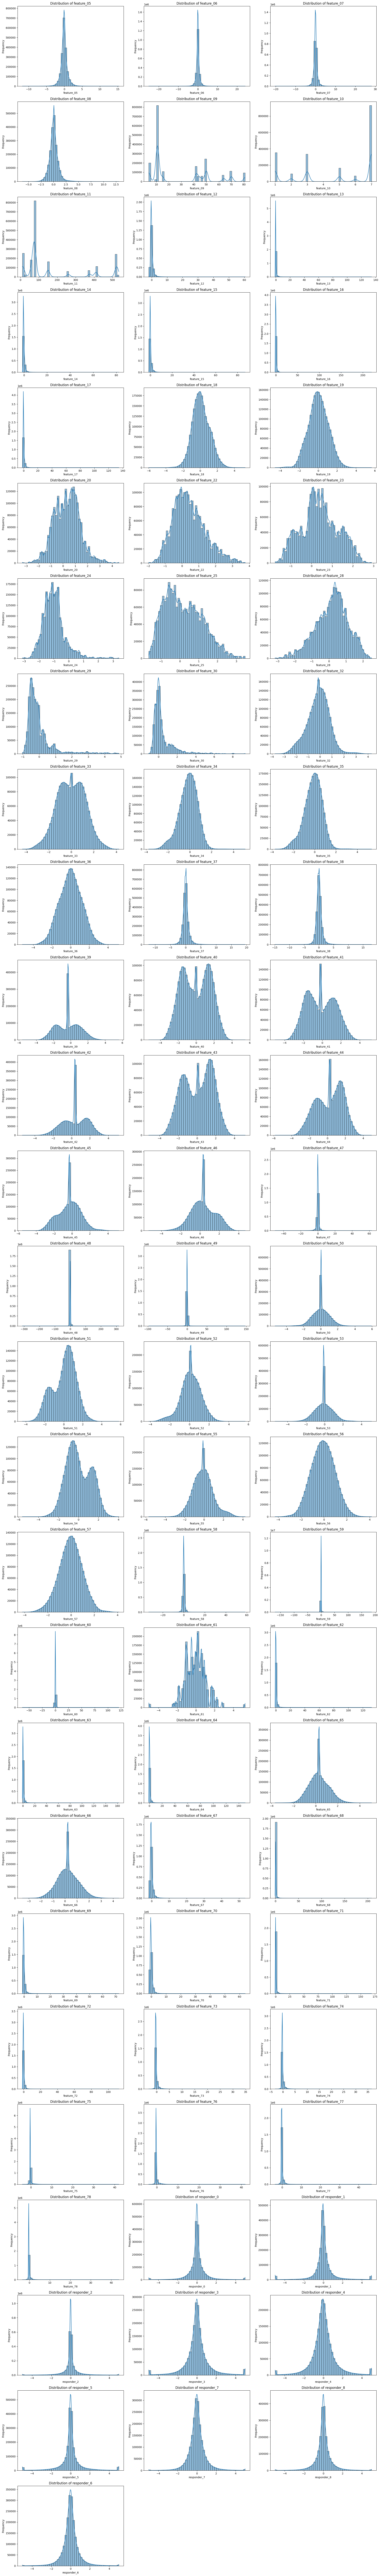


Plotting complete.


In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import time

data = df_cleaned
print("Plotting graphs:")

# Determine the number of features and responders
cols_to_plot = [col for col in data.columns if 'feature' in col or 'responder' in col]
n_cols = 3  # Number of columns in the grid
n_rows = (len(cols_to_plot) + n_cols - 1) // n_cols  # Calculate rows needed

# Create a grid of subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5 * n_rows))
axes = axes.flatten()  # Flatten the axes array for easy indexing

# Visualize distributions of features and responders
for i, col in enumerate(cols_to_plot):
    # Overwrite previous message in the same line
    sys.stdout.write(f'\rPlotting graph {i + 1}/{len(cols_to_plot)}...')
    sys.stdout.flush()
    
    sns.histplot(data[col], bins=50, kde=True, ax=axes[i])
    axes[i].set_title(f'Distribution of {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frequency')
    
    time.sleep(0.5) 
# Hide any unused subplots
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

# Adjust layout
plt.tight_layout()
plt.show()

print("\nPlotting complete.")

# Heatmaps
* > all the heatmaps are here

* ****heatmap between features and all responders****

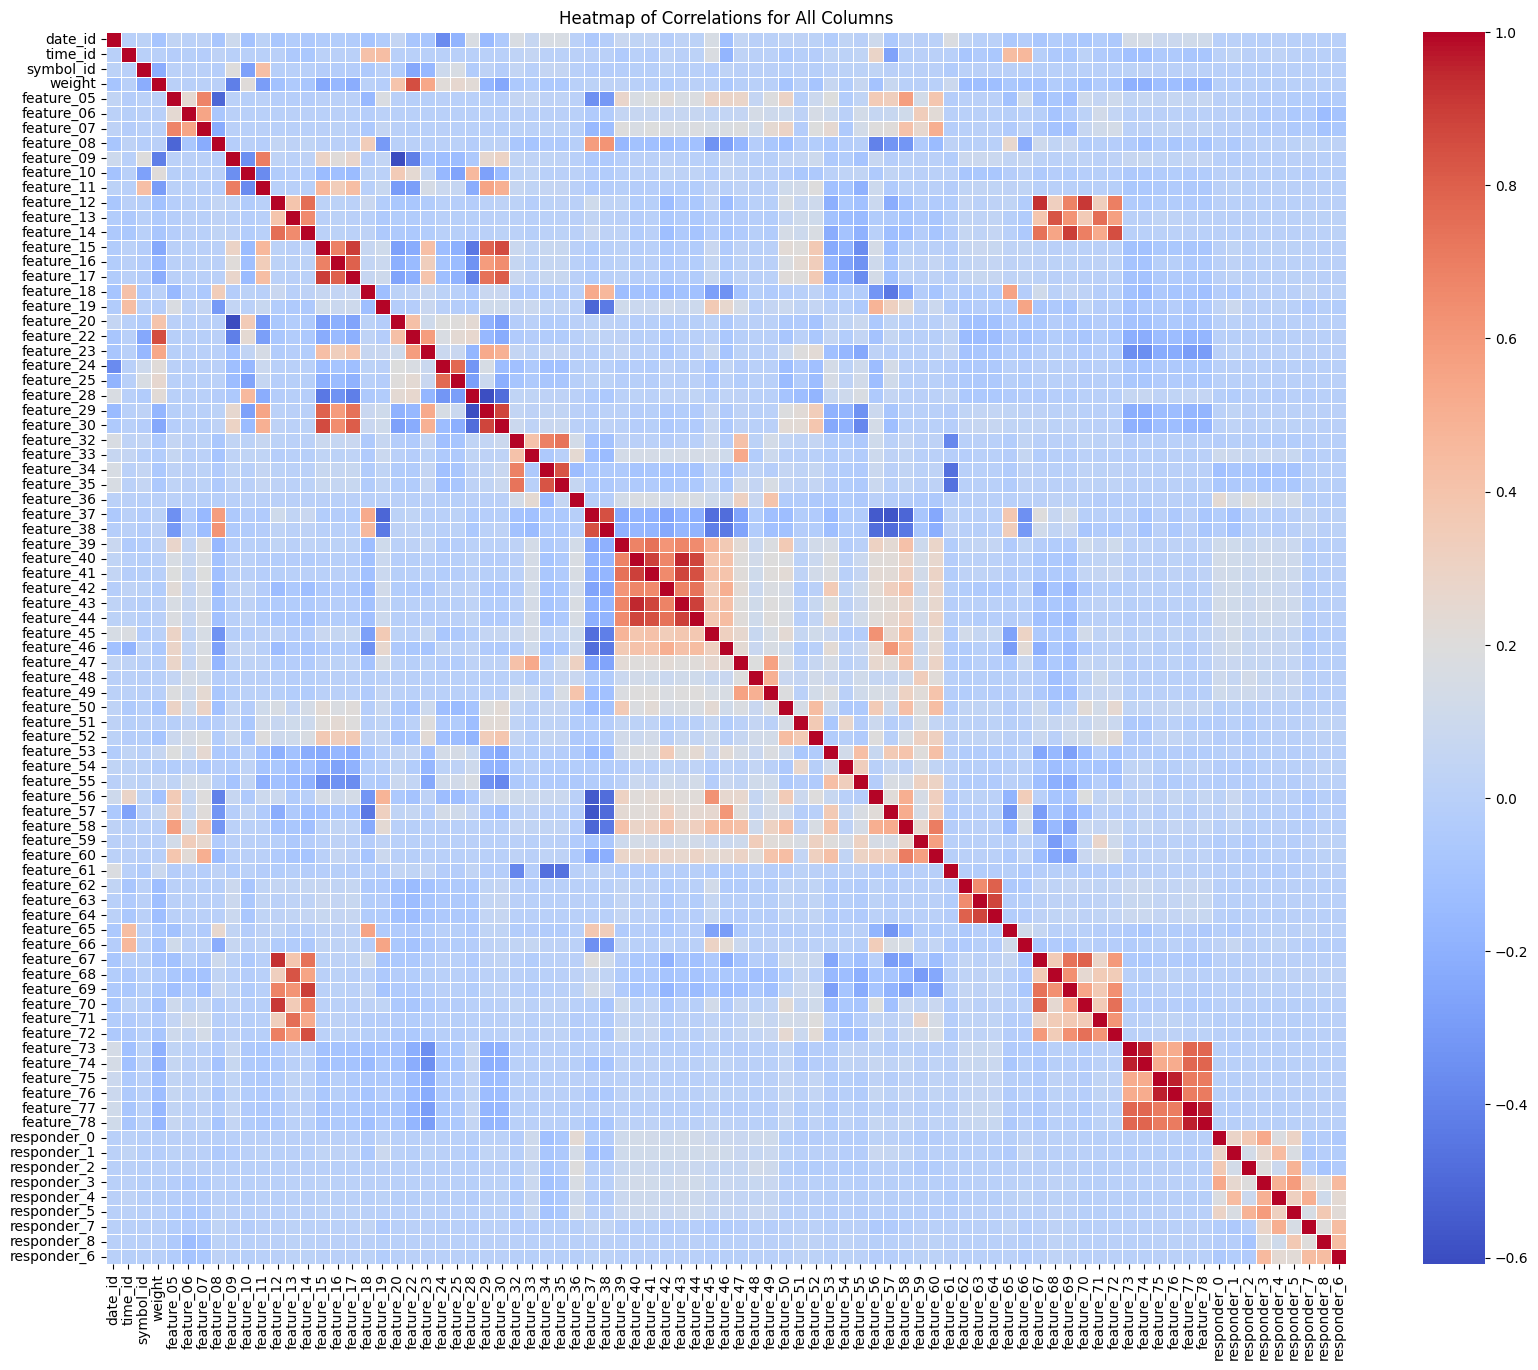

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

data = df_cleaned

# Set up the figure size for a large heatmap
plt.figure(figsize=(20, 16))

# Generate the heatmap for the entire dataset
sns.heatmap(data.corr(), annot=False, cmap='coolwarm', linewidths=0.5)

# Add title
plt.title('Heatmap of Correlations for All Columns')
plt.show()


> **heatmap between features and first responder**

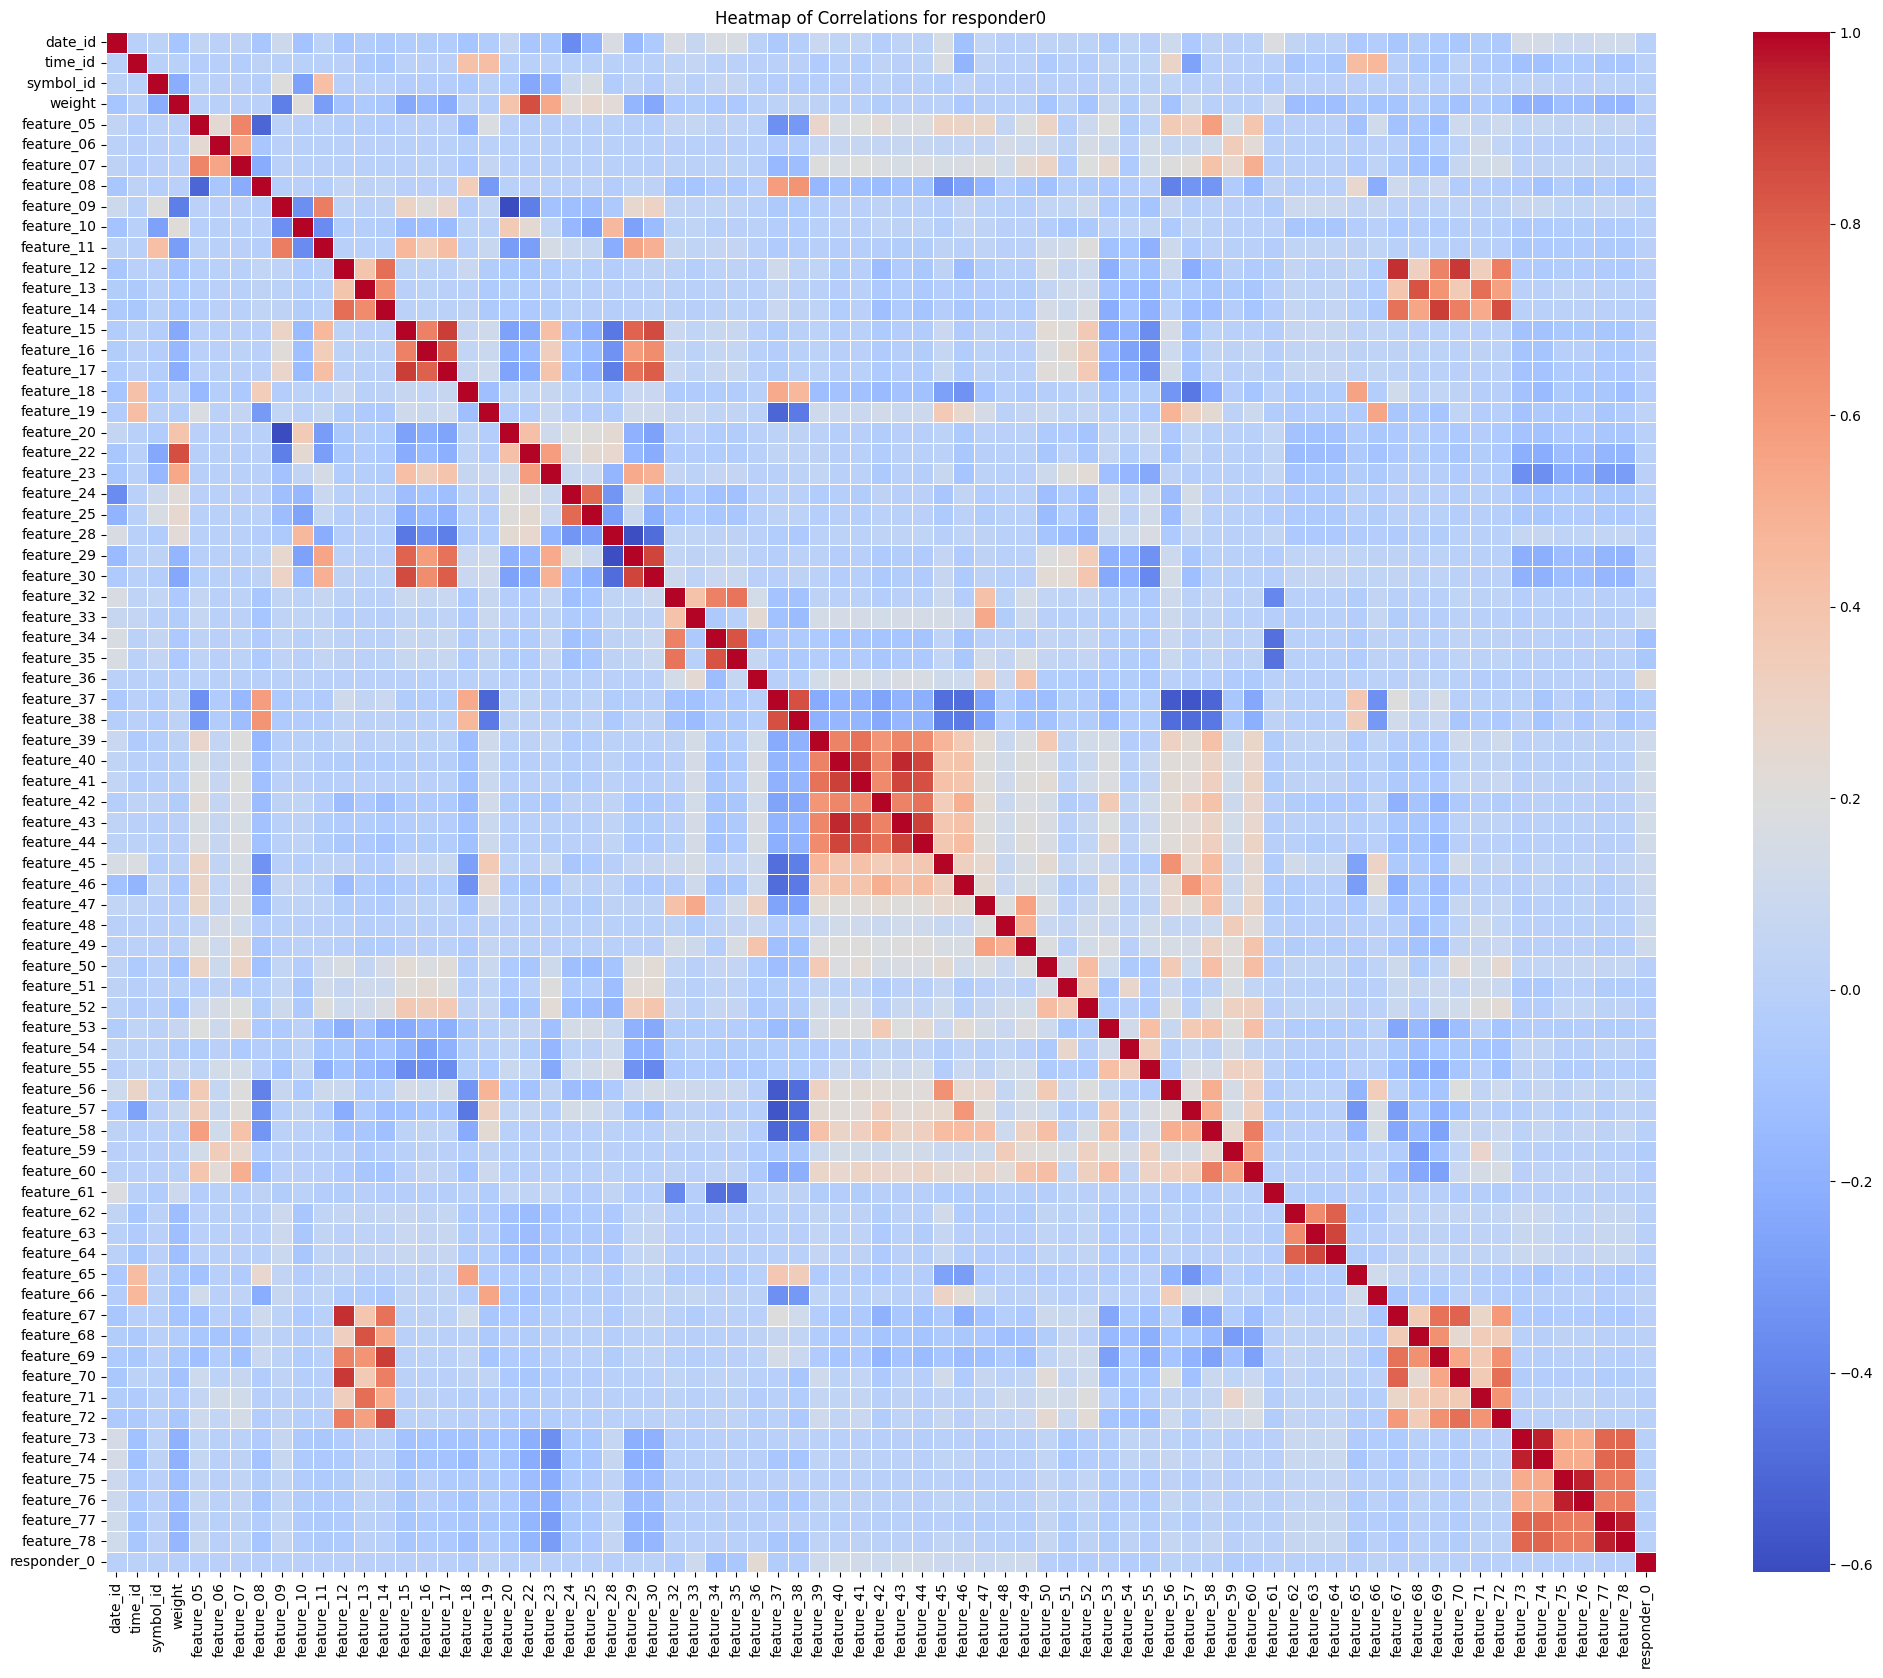

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

data = df_cleaned.iloc[:, :-8]

# Set up the figure size for a large heatmap
plt.figure(figsize=(25, 20))

# Generate the heatmap for the entire dataset
sns.heatmap(data.corr(), annot=False, cmap='coolwarm', linewidths=0.5)

# Add title
plt.title('Heatmap of Correlations for responder0')
plt.show()


> **heatmap between features and second responder**

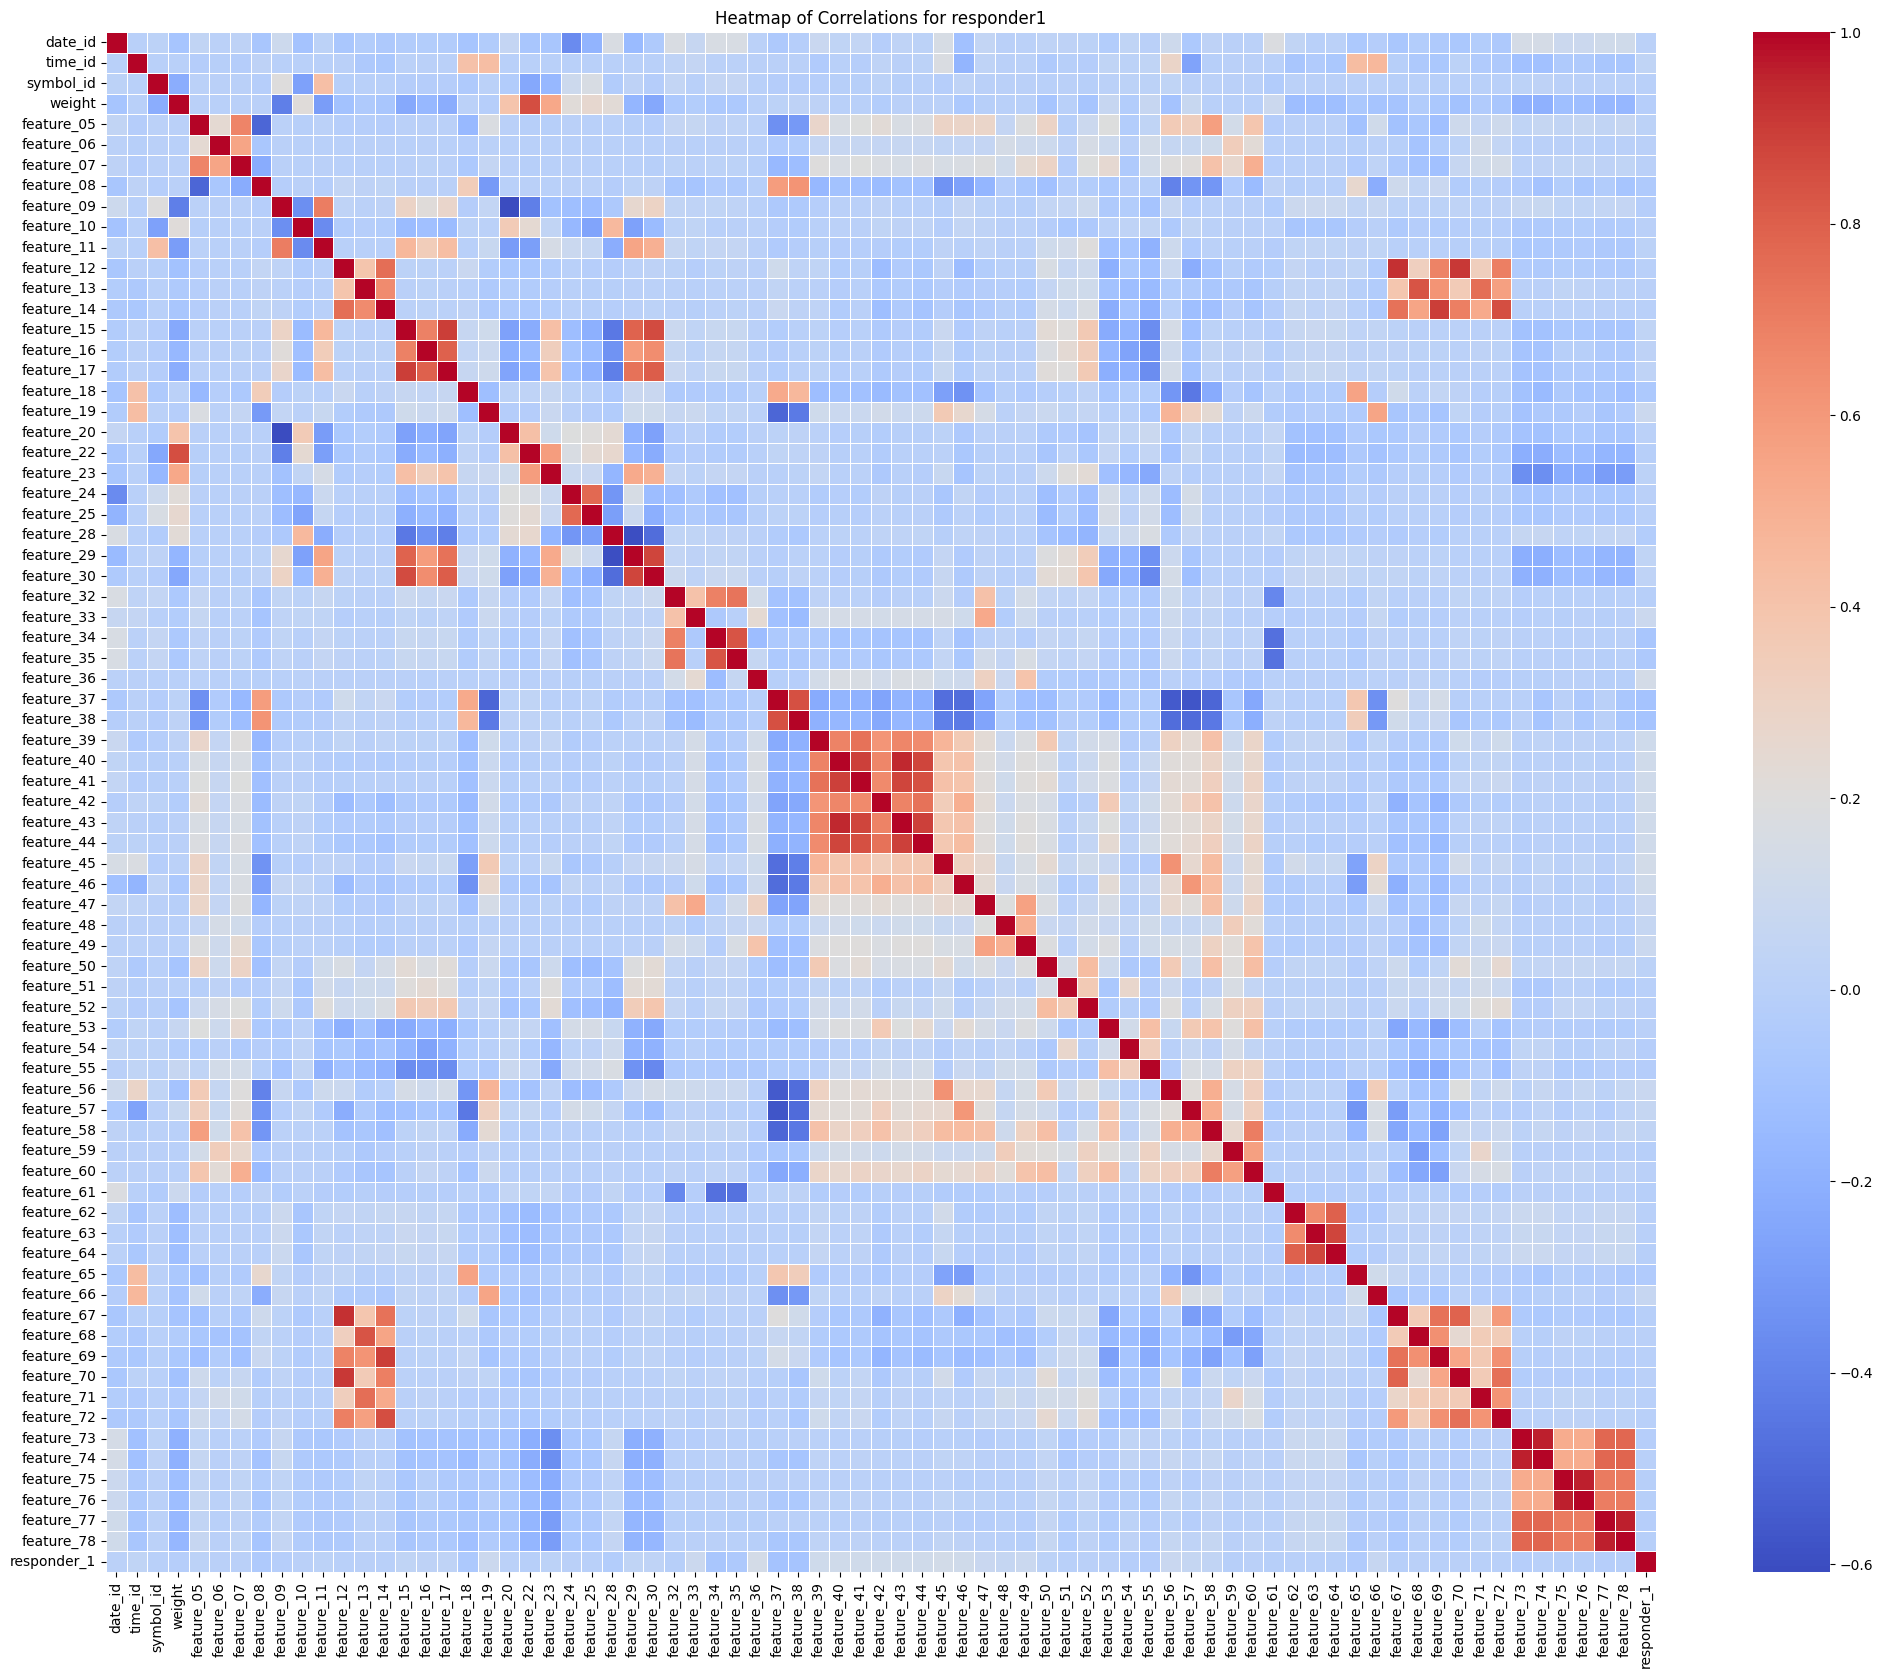

In [12]:
data = df_cleaned.iloc[:, :-7]
data = data.drop(data.columns[-2], axis=1)

# Set up the figure size for a large heatmap
plt.figure(figsize=(25, 20))

# Generate the heatmap for the entire dataset
sns.heatmap(data.corr(), annot=False, cmap='coolwarm', linewidths=0.5)

# Add title
plt.title('Heatmap of Correlations for responder1')
plt.show()


**Heatmap for the target variable (responder_6)**

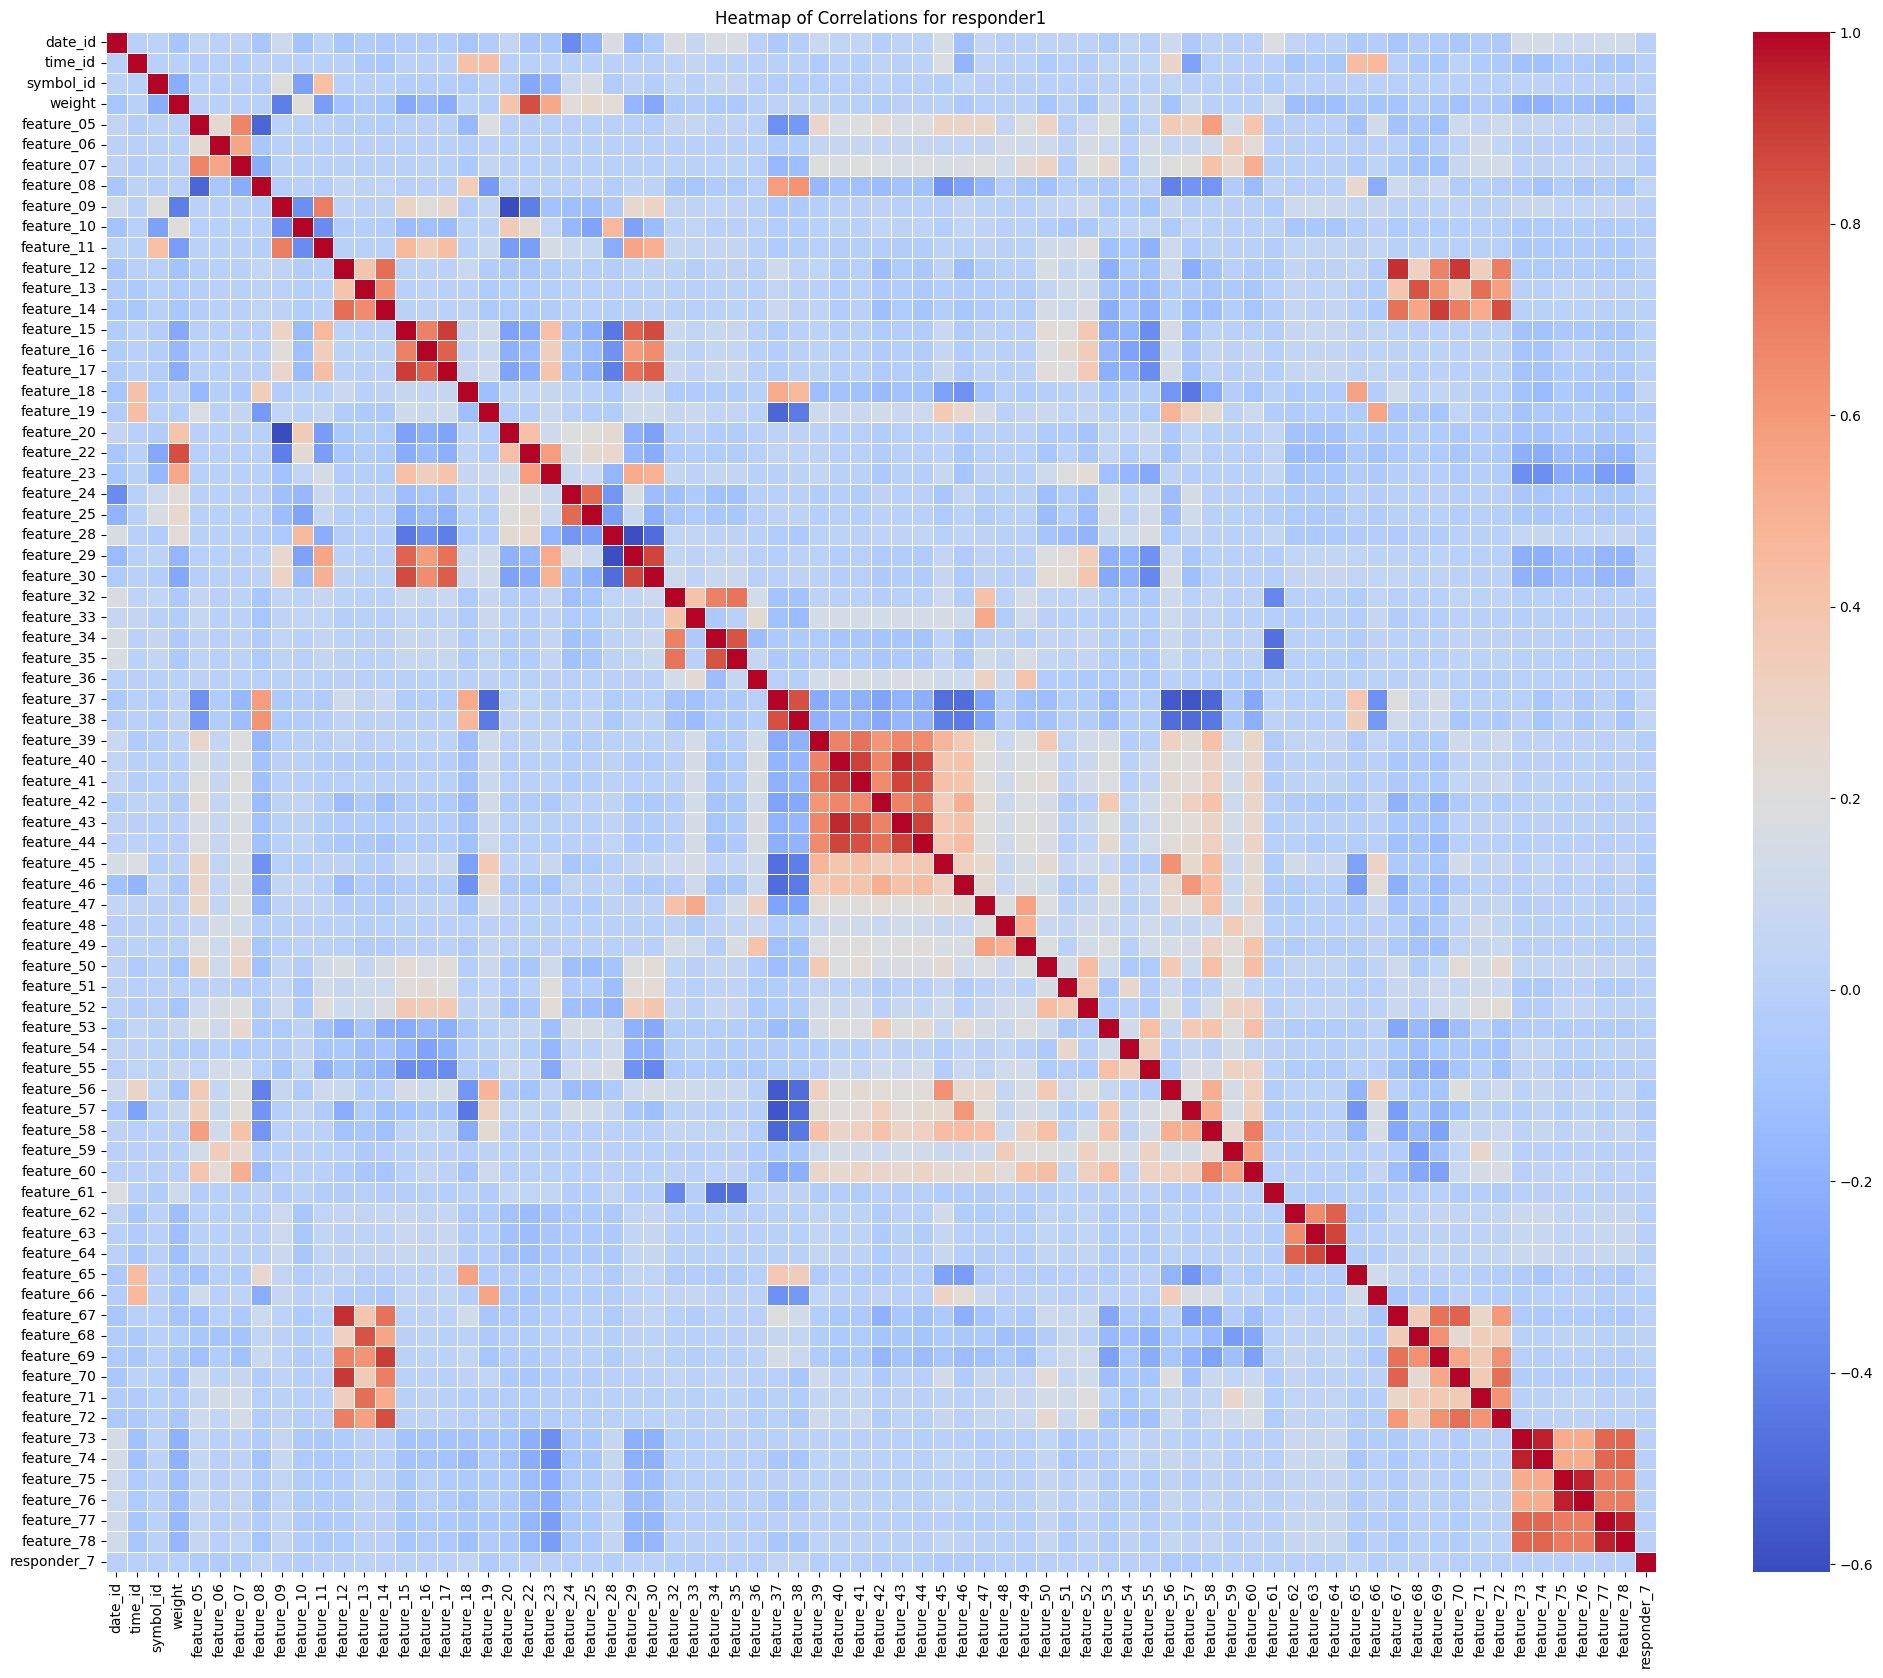

In [13]:
data = df_cleaned.iloc[:, :-2].drop(columns=['responder_0', 'responder_1', 'responder_2', 
                                 'responder_3', 'responder_4', 'responder_5'])

# Set up the figure size for a large heatmap
plt.figure(figsize=(25, 20))

# Generate the heatmap for the entire dataset
sns.heatmap(data.corr(), annot=False, cmap='coolwarm', linewidths=0.5)

# Add title
plt.title('Heatmap of Correlations for responder1')
plt.show()

# **XGBoost Model**

- **Data Preparation**: Select features and target (`responder_6`).
- **Train-Test Split**: Split data (80/20) without shuffling to preserve order.
- **Scaling**: Standardize features using `StandardScaler`.  ....(`altough not recommended`)
- **Model Training**: Train an XGBoost regressor on the scaled data.
- **Evaluation**: Calculate metrics like R², MAE, MSE, RMSE, MAPE, and accuracy within 10% of actual values.
- **Visualization**: Plot actual vs predicted values for the first 100 rows.

R-squared: 0.0149
Mean Absolute Error (MAE): 0.6576
Mean Squared Error (MSE): 0.9780
Root Mean Squared Error (RMSE): 0.9890
Mean Absolute Percentage Error (MAPE): 235.65%
Custom Accuracy (within 10% of actual): 1.17%


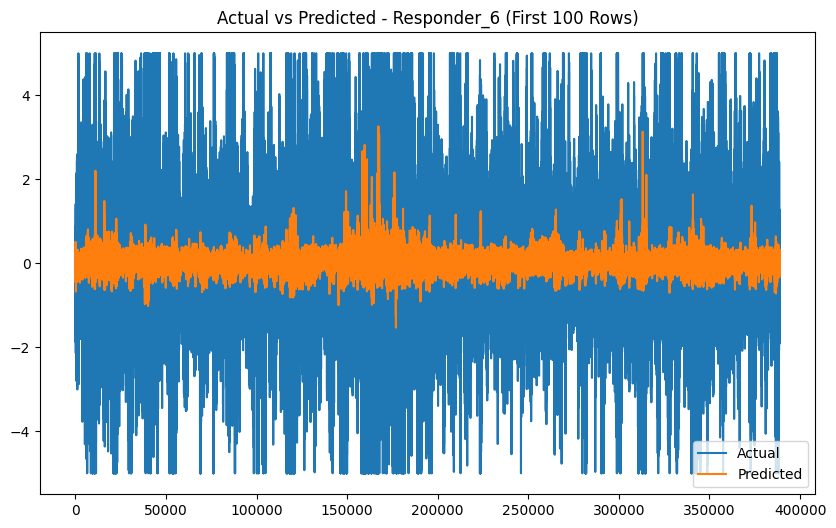

In [14]:
df_sample = df_cleaned

# Step 2: Select Features and Target
# Here 'responder_6' is the target variable (assumed), adjust if needed
target = 'responder_6'
features = [col for col in df_sample.columns if 'feature_' in col]

X = df_sample[features]  # Feature matrix
y = df_sample[target]    # Target variable

# Step 3: Train-Test Split
# Since this could be time-series data, make sure to split carefully
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Step 4: Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 5: Model Training (XGBoost)
model = XGBRegressor(objective='reg:squarederror', n_estimators=50, learning_rate=0.1)  # Reduced estimators for faster testing
model.fit(X_train_scaled, y_train)

# Step 6: Model Prediction
y_pred = model.predict(X_test_scaled)

# Step 7: Calculate Evaluation Metrics

# R-squared
r2 = r2_score(y_test, y_pred)

# Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, y_pred)

# Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred)

# Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)

# Mean Absolute Percentage Error (MAPE)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

# Custom Accuracy: Percentage of predictions within 10% of the actual values
accuracy = np.mean(np.abs((y_pred - y_test) / y_test) < 0.10) * 100

# Step 8: Print all metrics
print(f"R-squared: {r2:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
print(f"Custom Accuracy (within 10% of actual): {accuracy:.2f}%")

# Optional: Plot the predictions vs actuals
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
plt.plot(y_test.reset_index(drop=True), label='Actual')
plt.plot(y_pred, label='Predicted')
plt.title('Actual vs Predicted - Responder_6 (First 100 Rows)')
plt.legend()
plt.show()

In [15]:
# Select the specific row (e.g., row 89) as a sample input
sample_input = df.loc[[89], features]  # Use double brackets to maintain DataFrame structure

# Step 10: Scale the Sample Input
sample_input_scaled = scaler.transform(sample_input)

# Step 11: Make Predictions
sample_predictions = model.predict(sample_input_scaled)

# Step 12: Display Predictions
print("Sample Input Data:")
print(sample_input)
print("\nPredicted Value for Sample Input:")
print(sample_predictions)

Sample Input Data:
    feature_05  feature_06  feature_07  feature_08  feature_09  feature_10  \
89    0.653724   -0.084745    0.119095   -0.564572          11           7   

    feature_11  feature_12  feature_13  feature_14  ...  feature_69  \
89          76   -1.114549    -0.35649   -0.583195  ...   -0.164523   

    feature_70  feature_71  feature_72  feature_73  feature_74  feature_75  \
89   -0.978206   -0.312797   -0.624864   -0.498919   -0.348725   -0.277771   

    feature_76  feature_77  feature_78  
89   -0.250952   -0.357971   -0.194685  

[1 rows x 70 columns]

Predicted Value for Sample Input:
[-0.6979831]


# **LSTM for Time Series Analysis**

In [16]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

data = df_cleaned
# Step 1: Prepare the data
target_column = 'responder_6'
features = data.drop(columns=[target_column]).values  # Feature matrix
target = data[target_column].values  # Target variable

# Scale the features
scaler = MinMaxScaler()
features_scaled = scaler.fit_transform(features)

# Create sequences for LSTM
def create_sequences(data, target, time_steps=1):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:(i + time_steps)])
        y.append(target[i + time_steps])
    return np.array(X), np.array(y)

# Set the number of time steps
time_steps = 5
X, y = create_sequences(features_scaled, target, time_steps)

# Step 2: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Step 3: Reshape input to be [samples, time steps, features]
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], X_train.shape[2]))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], X_test.shape[2]))

# Step 4: Build the LSTM model
model = Sequential()
model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(50, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1))  # Output layer for regression

# Step 5: Compile and fit the model
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=50, batch_size=32)

# Step 6: Model prediction
y_pred = model.predict(X_test)

# Step 7: Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse:.4f}')
print(f'R-squared: {r2:.4f}')


Epoch 1/50


I0000 00:00:1729068280.822028      90 service.cc:145] XLA service 0x7eed8c00a4a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1729068280.822073      90 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


   62/48606 ━━━━━━━━━━━━━━━━━━━━ 2:01 3ms/step - loss: 0.6900

I0000 00:00:1729068284.933368      90 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


48606/48606 ━━━━━━━━━━━━━━━━━━━━ 125s 2ms/step - loss: 0.6979
Epoch 2/50
48606/48606 ━━━━━━━━━━━━━━━━━━━━ 117s 2ms/step - loss: 0.6972
Epoch 3/50
48606/48606 ━━━━━━━━━━━━━━━━━━━━ 117s 2ms/step - loss: 0.6893
Epoch 4/50
48606/48606 ━━━━━━━━━━━━━━━━━━━━ 117s 2ms/step - loss: 0.6926
Epoch 5/50
48606/48606 ━━━━━━━━━━━━━━━━━━━━ 118s 2ms/step - loss: 0.6902
Epoch 6/50
48606/48606 ━━━━━━━━━━━━━━━━━━━━ 117s 2ms/step - loss: 0.6897
Epoch 7/50
48606/48606 ━━━━━━━━━━━━━━━━━━━━ 117s 2ms/step - loss: 0.6834
Epoch 8/50
48606/48606 ━━━━━━━━━━━━━━━━━━━━ 117s 2ms/step - loss: 0.6872
Epoch 9/50
48606/48606 ━━━━━━━━━━━━━━━━━━━━ 117s 2ms/step - loss: 0.6844
Epoch 10/50
48606/48606 ━━━━━━━━━━━━━━━━━━━━ 118s 2ms/step - loss: 0.6833
Epoch 11/50
48606/48606 ━━━━━━━━━━━━━━━━━━━━ 117s 2ms/step - loss: 0.6851
Epoch 12/50
48606/48606 ━━━━━━━━━━━━━━━━━━━━ 118s 2ms/step - loss: 0.6836
Epoch 13/50
48606/48606 ━━━━━━━━━━━━━━━━━━━━ 119s 2ms/step - loss: 0.6834
Epoch 14/50
48606/48606 ━━━━━━━━━━━━━━━━━━━━ 118s 2ms/step